Text(0,0.5,'slag formation rate, %/s')

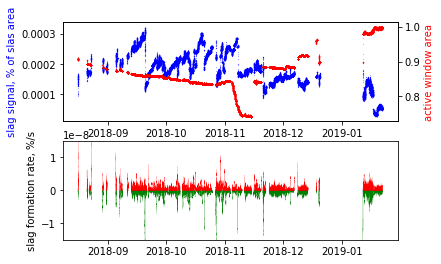

In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import datetime
import matplotlib.pyplot as pl
import numpy as np
%matplotlib inline

file_path = 'C:/Users/ehsanfo/Downloads/py_to_ipynb/excerpt_2019_01_21_active_area.csv'

slag_history = np.genfromtxt(file_path, delimiter=',')

#%% differentials
# area of mask
SIGNAL_MAX = 123250
dts = [datetime.datetime.utcfromtimestamp(t) for t in slag_history[:,0]]
d_slag = np.diff(slag_history[:,1] / SIGNAL_MAX)
d_time = np.diff(slag_history[:,0])

# d_time statistics
d_time_median = np.median(d_time)

# find contiguous time
d_time_threshold = d_time_median * 20
d_time_edges = d_time > d_time_threshold

d_time_edge_inds = np.array([0, 
                             *(np.nonzero(d_time_edges)[0].tolist()), 
                             d_time.size])

def scattered_moving_average(data, window_size):
    def window(x, x_current):
        return (np.abs(x_current - x) < window_size).astype(np.float)
    result = np.zeros(data[:,1].shape)
    for i, x in enumerate(data[:,0]):
        w = window(data[:,0], x)
        result[i] = np.sum(data[:,1] * w) / np.sum(w)
    return result

rate_data = np.stack((slag_history[1:,0], d_slag)).transpose()
times_smoothed = np.array([])
d_slag_smoothed = np.array([])
for i, ind in enumerate(d_time_edge_inds[:-1]):
    d_time_current = d_time[ind:d_time_edge_inds[i+1]]
    d_slag_current = d_slag[ind:d_time_edge_inds[i+1]] / d_time_current
    times_current = slag_history[1:,0][ind:d_time_edge_inds[i+1]]
    times_smoothed = np.append(times_smoothed, times_current)
    d_slag_smoothed = np.append(d_slag_smoothed, 
        scattered_moving_average(
            np.stack((times_current, d_slag_current)).transpose(), 3600))

#%%

ax1 = pl.subplot(2, 1, 1)
ax1.plot(dts, slag_history[:,1] / SIGNAL_MAX * 100, '.', markersize=0.25,
          color='b')
ax1.set_ylabel('slag signal, % of slas area')
ax1.yaxis.label.set_color('b')
ax2_ = ax1.twinx()
ax2_.plot(dts, slag_history[:,2] / max(slag_history[:,2]), '.', markersize=0.25,
          color='r')
ax2_.set_ylabel('active window area')
ax2_.yaxis.label.set_color('r')

pl.subplot(2, 1, 2, sharex=ax1)
dts_smoothed = [datetime.datetime.utcfromtimestamp(a) for a in times_smoothed]
for i, ind in enumerate(d_time_edge_inds[:-1]):
    from_ = ind
    to_ = d_time_edge_inds[i+1]
    pl.fill_between(dts_smoothed[from_:to_], d_slag_smoothed[from_:to_] * 100, 
                    where=d_slag_smoothed[from_:to_]<0,
                    color='g', linewidth=0.1)
    pl.fill_between(dts_smoothed[from_:to_], d_slag_smoothed[from_:to_] * 100, 
                    where=d_slag_smoothed[from_:to_]>0, 
                    color='r', linewidth=0.1)
pl.ylim([-1.5e-8, 1.5e-8])
pl.ylabel('slag formation rate, %/s')

